In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Activation
from tensorflow.compat.v1.keras.layers import Bidirectional, CuDNNLSTM, Dropout, Dense, Activation
from matplotlib.dates import DateFormatter, AutoDateLocator
import lightgbm as lgb


In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
def get_data(file_name):
  df = pd.read_csv(file_name)
  df = df[::-1].reset_index(drop=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  return df

In [4]:
def split_data_set(df, ratio):
  split_point = int((len(df)) * ratio)
  print(split_point)
  time_train = df['Date'][:split_point]
  x_train = df['Price'][:split_point]

  time_valid = df['Date'][split_point:]
  x_valid = df['Price'][split_point:]

  return time_train, x_train, time_valid, x_valid

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [43]:
def add_features(df):
  window = 10
  df['Price_MA'] = df['Price'].rolling(window=window_size).mean()
  df['Price_1Lag'] = df['Price'].shift(1)
  df['Price_2Lag'] = df['Price'].shift(2)
  # df.fillna(0, inplace=True)
  df.dropna(inplace=True)
  return df

In [9]:
# Parameters

window_size = 3
batch_size = 32
shuffle_buffer_size = 1000

def get_train_set(x_train):

  # Generate the dataset windows
  # train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
  train_set = add_features(train_set)
  return train_set

In [12]:
# Build the Model

def build_model(window_size):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
  model.summary()
  return model


In [11]:
def build_model_lgbm():
  params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
  }
  lgb_model = lgb.LGBMRegressor(**params, n_estimators=500)
  return lgb_model

In [14]:
def tune_model(model, train_set):
  init_weights = model.get_weights()
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

  # Initialize the optimizer
  optimizer = tf.keras.optimizers.SGD(momentum=0.9)

  # Set the training parameters
  model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

  # Train the model
  history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

  # Define the learning rate array
  lrs = 1e-8 * (10 ** (np.arange(100) / 20))

  # Set the figure size
  plt.figure(figsize=(10, 6))

  # Set the grid
  plt.grid(True)

  # Plot the loss in log scale
  plt.semilogx(lrs, history.history["loss"])

  # Increase the tickmarks size
  plt.tick_params('both', length=10, width=1, which='both')

  # Set the plot boundaries
  plt.axis([1e-8, 1e-3, 0, 100])

  # Reset states generated by Keras
  tf.keras.backend.clear_session()

  # Reset the weights
  model.set_weights(init_weights)

  # Set the learning rate
  learning_rate = 8e-7

  # Set the optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

  # Set the training parameters
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  return model


In [15]:
# Train the model

def run_model(model, train_set):
  history = model.fit(train_set,epochs=100)

  # Get mae and loss from history log
  mae=history.history['mae']
  loss=history.history['loss']

  # Get number of epochs
  epochs=range(len(loss))

  # Plot mae and loss
  plot_series(
      x=epochs,
      y=(mae, loss),
      title='MAE and Loss',
      xlabel='MAE',
      ylabel='Loss',
      legend=['MAE', 'Loss']
      )

  # Only plot the last 80% of the epochs
  zoom_split = int(epochs[-1] * 0.2)
  epochs_zoom = epochs[zoom_split:]
  mae_zoom = mae[zoom_split:]
  loss_zoom = loss[zoom_split:]

  # Plot zoomed mae and loss
  plot_series(
      x=epochs_zoom,
      y=(mae_zoom, loss_zoom),
      title='MAE and Loss',
      xlabel='MAE',
      ylabel='Loss',
      legend=['MAE', 'Loss']
      )


In [35]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [38]:
def model_forecast_runner(df, ratio, time_valid, x_valid):
  split_point = int((len(df)) * ratio)
  series = df['Price']
  forecast_series = series[split_point-window_size:-1]

  forecast = model_forecast(model, forecast_series, window_size, batch_size)
  # Drop single dimensional axis
  results = forecast.squeeze()
  print(results)

  # Plot the results
  plot_series(time_valid, (x_valid, results))
  print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


### Functions LGBM Model

In [20]:
def train_test_split(df):
  split_point = (int(len(df) * 0.75))
  df_new = df.drop(['Date', 'Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
  df_train = df_new[:split_point]
  df_test = df_new[split_point:]
  x_train = df_train.drop('Price', axis=1)
  y_train = df_train['Price']
  x_test = df_test.drop('Price', axis=1)
  y_test = df_test['Price']
  return x_train, y_train, x_test, y_test

# Testing the Model

In [7]:
df = get_data("Ethereum Historical Data - Investing.com India.csv")

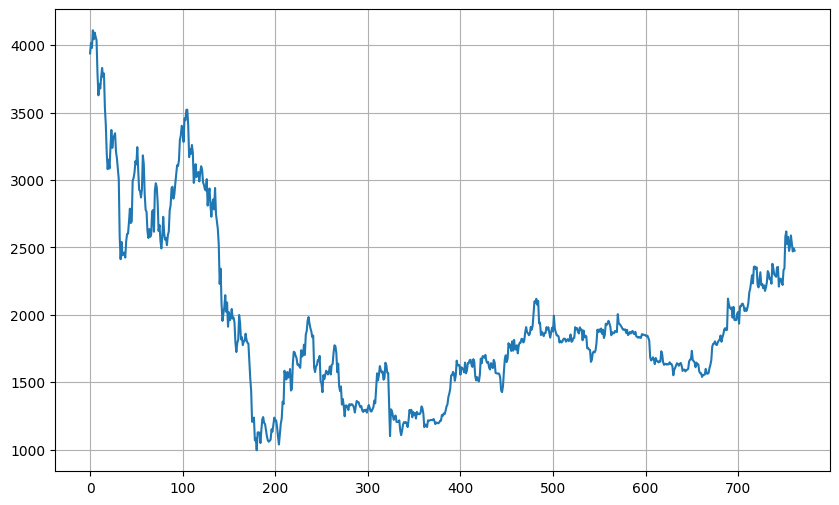

In [16]:
plot_series(x=df.index, y=df['Price'], start=0)

In [14]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 20, 2021",3938.80,"3,925.46","3,978.66","3,757.42",531.11K,0.34%
1,"Dec 21, 2021",4016.59,"3,944.03","4,058.76","3,915.56",496.71K,1.98%
2,"Dec 22, 2021",3979.54,"4,016.25","4,072.40","3,944.15",426.43K,-0.92%
3,"Dec 23, 2021",4110.14,"3,979.57","4,149.17","3,895.89",573.18K,3.28%
4,"Dec 24, 2021",4043.39,"4,110.20","4,133.77","4,024.24",353.85K,-1.62%
...,...,...,...,...,...,...,...
757,"Jan 16, 2024",2588.64,"2,511.95","2,613.71","2,501.00",395.07K,3.05%
758,"Jan 17, 2024",2531.26,"2,588.63","2,592.88","2,510.00",380.90K,-2.22%
759,"Jan 18, 2024",2469.77,"2,531.26","2,548.79","2,430.97",467.22K,-2.43%
760,"Jan 19, 2024",2491.81,"2,469.77","2,504.09","2,418.61",443.42K,0.89%


In [25]:
time_train, x_train, time_valid, x_valid = split_data_set(df, 0.75)

571


In [26]:
train_set = get_train_set(x_train)

In [27]:
model = build_model(30)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

Epoch 1/100
17/17 [==============================] - 4s 29ms/step - loss: 1856.0520 - lr: 1.0000e-08
Epoch 2/100
17/17 [==============================] - 0s 25ms/step - loss: 1831.6241 - lr: 1.1220e-08
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 1815.5515 - lr: 1.2589e-08
Epoch 4/100
17/17 [==============================] - 0s 25ms/step - loss: 1810.3298 - lr: 1.4125e-08
Epoch 5/100
17/17 [==============================] - 0s 23ms/step - loss: 1806.3435 - lr: 1.5849e-08
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 1802.0436 - lr: 1.7783e-08
Epoch 7/100
17/17 [==============================] - 0s 26ms/step - loss: 1797.3219 - lr: 1.9953e-08
Epoch 8/100
17/17 [==============================] - 0s 25ms/step - loss: 1792.3639 - lr: 2.2387e-08
Epoch 9/100
17/17 [==============================] - 1s 29ms/step - loss: 1786.8872 - lr: 2.5119e-08
Epoch 10/100
17/17 [==============================] - 1s 33ms/step - loss: 1780.8055 - lr: 

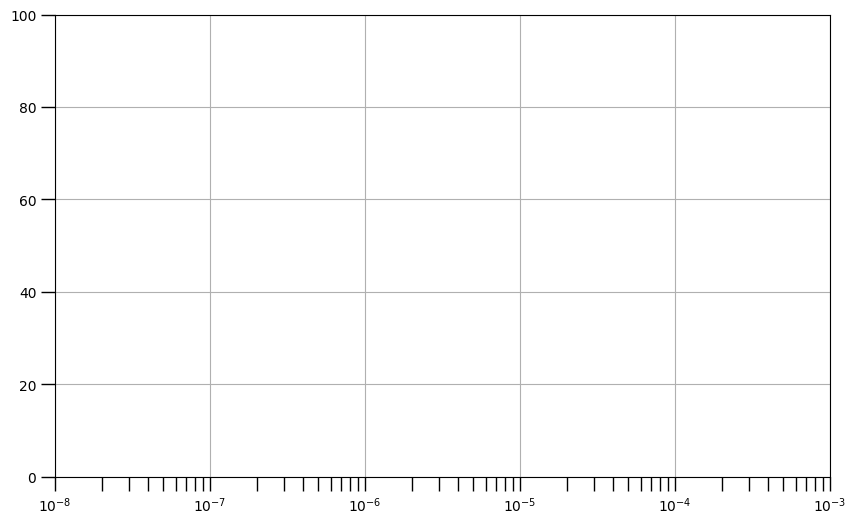

In [28]:
model = tune_model(model, train_set)

Epoch 1/100
17/17 [==============================] - 4s 26ms/step - loss: 1782.8898 - mae: 1783.3898
Epoch 2/100
17/17 [==============================] - 0s 25ms/step - loss: 1624.1133 - mae: 1624.6133
Epoch 3/100
17/17 [==============================] - 0s 25ms/step - loss: 1438.6455 - mae: 1439.1455
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 1165.0298 - mae: 1165.5298
Epoch 5/100
17/17 [==============================] - 0s 25ms/step - loss: 734.3996 - mae: 734.8990
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 459.5757 - mae: 460.0756
Epoch 7/100
17/17 [==============================] - 0s 25ms/step - loss: 445.6986 - mae: 446.1985
Epoch 8/100
17/17 [==============================] - 0s 23ms/step - loss: 437.2823 - mae: 437.7822
Epoch 9/100
17/17 [==============================] - 0s 25ms/step - loss: 437.6220 - mae: 438.1220
Epoch 10/100
17/17 [==============================] - 0s 25ms/step - loss: 437.7733 - mae: 438.2733
E

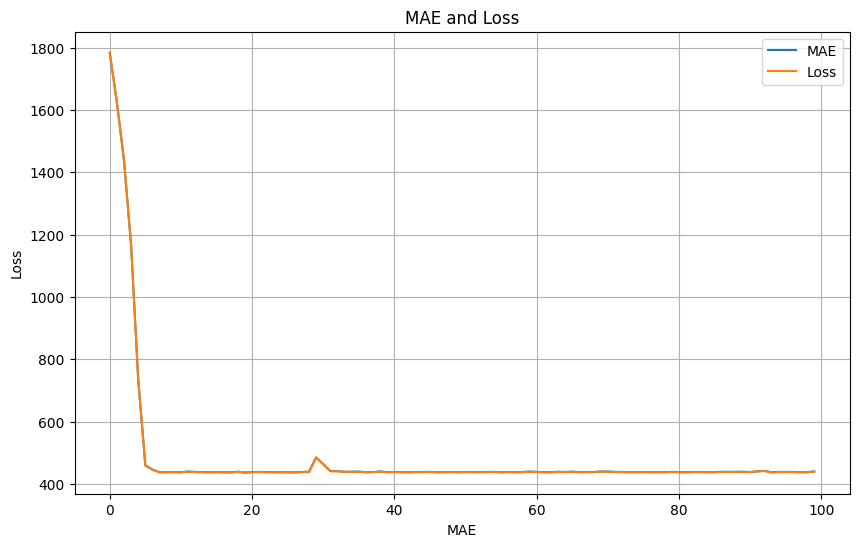

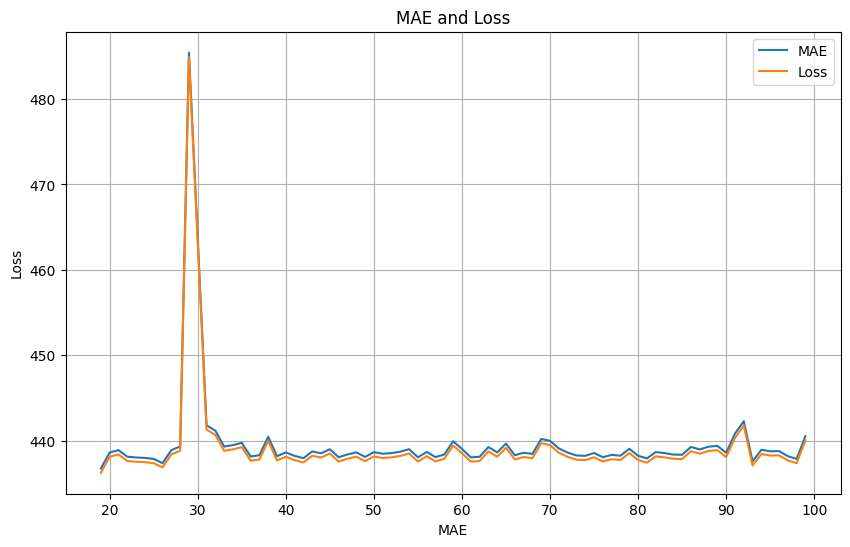

In [29]:
run_model(model, train_set)

6/6 [==============================] - 0s 11ms/step
[1701.2354 1701.235  1701.2357 1701.236  1701.236  1701.2354 1701.235
 1701.237  1701.2367 1701.237  1701.2367 1701.2369 1701.2367 1701.2369
 1701.2366 1701.2356 1701.2373 1701.2369 1701.2369 1701.2375 1701.2373
 1701.237  1701.2366 1701.2367 1701.2369 1701.2369 1701.2369 1701.237
 1701.2344 1701.2379 1701.2375 1701.2375 1701.2373 1701.237  1701.237
 1701.2367 1701.2369 1701.2369 1701.2366 1701.237  1701.2367 1701.2367
 1701.237  1701.2367 1701.2367 1701.2369 1701.2367 1701.2367 1701.2369
 1701.2366 1701.2366 1701.2367 1701.2366 1701.2367 1701.2366 1701.2367
 1701.2367 1701.2367 1701.2367 1701.2367 1701.2367 1701.2367 1701.2367
 1701.2367 1701.2357 1701.2354 1701.2356 1701.2357 1701.236  1701.2349
 1701.2357 1701.2356 1701.2356 1701.2352 1701.2354 1701.2344 1701.2363
 1701.2362 1701.2354 1701.2352 1701.2354 1701.2354 1701.2352 1701.2352
 1701.2352 1701.2354 1701.2352 1701.2356 1701.2352 1701.2343 1701.2352
 1701.235  1701.2352 1701.23

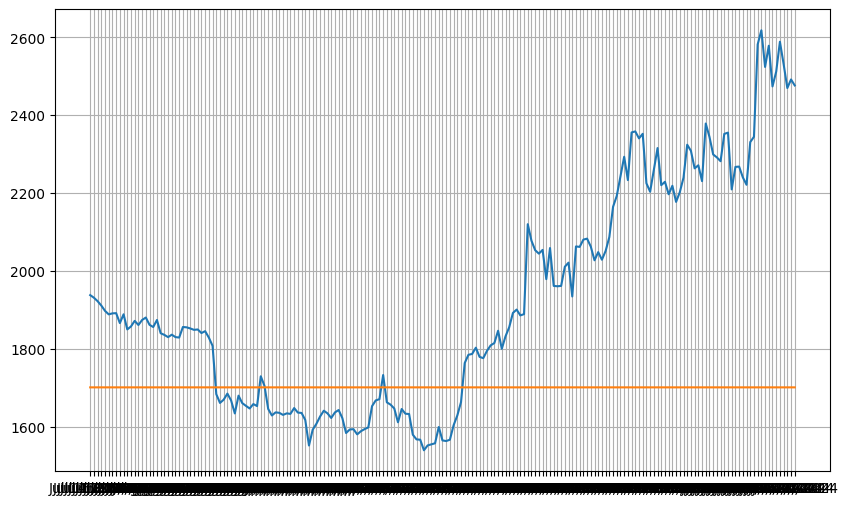

271.50656


In [39]:
model_forecast_runner(df, 0.75, time_valid, x_valid)

### LGBM Model test Run

In [17]:
model = build_model_lgbm()

In [44]:
df_added = add_features(df)

In [45]:
df_added

,Date,Price,Open,High,Low,Vol.,Change %,Price_MA,Price_1Lag,Price_2Lag
29,"Jan 18, 2022",3160.15,"3,209.43","3,242.47","3,084.48",399.19K,-1.53%,3596.316000,3209.35,3346.59
30,"Jan 19, 2022",3083.65,"3,160.15","3,173.63","3,049.30",459.81K,-2.42%,3567.811000,3160.15,3209.35
31,"Jan 20, 2022",3004.72,"3,084.48","3,270.71","2,989.19",481.08K,-2.56%,3534.082000,3083.65,3160.15
32,"Jan 21, 2022",2571.29,"3,000.21","3,032.69","2,471.80",1.42M,-14.43%,3487.140333,3004.72,3083.65
33,"Jan 22, 2022",2412.52,"2,570.67","2,621.21","2,311.80",1.48M,-6.17%,3430.553000,2571.29,3004.72
...,...,...,...,...,...,...,...,...,...,...
757,"Jan 16, 2024",2588.64,"2,511.95","2,613.71","2,501.00",395.07K,3.05%,2343.299667,2511.94,2473.96
758,"Jan 17, 2024",2531.26,"2,588.63","2,592.88","2,510.00",380.90K,-2.22%,2353.715000,2588.64,2511.94
759,"Jan 18, 2024",2469.77,"2,531.26","2,548.79","2,430.97",467.22K,-2.43%,2363.459333,2531.26,2588.64
760,"Jan 19, 2024",2491.81,"2,469.77","2,504.09","2,418.61",443.42K,0.89%,2373.113333,2469.77,2531.26


In [46]:
x_train, y_train, x_test, y_test = train_test_split(df_added)

In [47]:
x_train

,Price_MA,Price_1Lag,Price_2Lag
29,3596.316000,3209.35,3346.59
30,3567.811000,3160.15,3209.35
31,3534.082000,3083.65,3160.15
32,3487.140333,3004.72,3083.65
33,3430.553000,2571.29,3004.72
...,...,...,...
573,1876.887667,1931.42,1938.05
574,1883.002667,1922.45,1931.42
575,1888.889333,1911.24,1922.45
576,1893.942333,1897.58,1911.24


In [48]:
model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 549, number of used features: 3
[LightGBM] [Info] Start training from score 1853.615954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LGBMRegressor(feature_fraction=0.9, learning_rate=0.05, metric='rmse',
              n_estimators=500, objective='regression')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


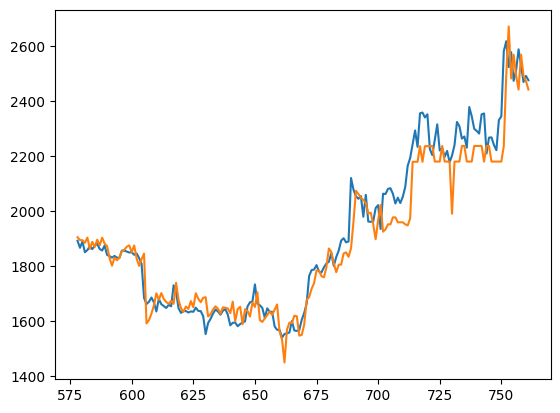

In [49]:
y_pred = model.predict(x_test)

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_pred)
plt.show()